<a href="https://colab.research.google.com/github/janmechtel/party/blob/master/Scraper3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scrape a category or the entire corpus of wikipedia for a given language.

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/04/5-amazing-google-colab-hacks-you-should-try-today/
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DRIVE = './drive/MyDrive/Marvin/ru.wp'
BATCH_PAGEIDS = 50

In [ ]:
from datetime import datetime
import os
import pytz
import requests
from typing import List, Union

def init_session():
  """ (Re)Start session and re-use for session obj multiple queries. """
  return requests.Session()

def get_logfile(country_code, suffix:Union[str, List[str]]=None):
  logfile = country_code
  if suffix:
    logfile += '_' + suffix if type(suffix) == str else '_'.join(suffix)
  tz = pytz.timezone('Europe/Berlin')
  berlin_now = str(datetime.now(tz)).replace(' ', 'T')
  pos = berlin_now.find('.')
  ts = berlin_now[:pos]
  return os.path.join(DRIVE, logfile + '_' + ts + '.csv')

def get_api_url(country_code: str='en', params: dict=None):
  api_url = 'https://{}.wikipedia.org/w/api.php'.format(country_code)
  if params:
    api_url += '?' + '&'.join([k + '=' + str(v) for k, v in params.items()])
  return api_url

def get_link(country_code:str, pageid:Union[int, str]):
  return 'https://{}.wikipedia.org/w/index.php?curid={}'.format(country_code, pageid)


In [ ]:
import copy
from datetime import datetime
from pandas import DataFrame
import requests
import sys
import traceback
from typing import List, Optional, Union

# fields to collect
COLUMNS = ('user', 'pageid', 'revid','timestamp')

# api url arguments
PARAMS = {
    "action": "query",
    "arvprop": 'ids|flags|timestamp|user|size|contentmodel|content|comment|tags',
    'arvslots': 'main',
    "format": "json"
}

DELIM = ';'

# batch size for pageids query

BATCH = 50

def collect_fields(data: dict) -> DataFrame:
  #print('data = ', data)
  edits = DataFrame(columns = COLUMNS)
  idx = 0
  for entry in data["query"]["allrevisions"]:
      pageid = entry['pageid']
      for revision in entry['revisions']:
        edits.loc[idx] = [revision['user'], pageid, revision['revid'], revision['timestamp']]
        idx += 1
  print('edits in collect_fields = ', edits)
  return edits

def get_edit_stats_by_user(session: requests.Session, user: str, country_code: Optional[Union[str, List[str]]]=None):
  """ Get edit stats for a given user for all pages. """
  URL = get_api_url(country_code)
  params = copy.copy(PARAMS)
  params['arvuser'] = user
  if country_code:
    urls = [URL.format(country_code)]
  else:
    urls = [URL.format(cc) for cc in COUNTRY_CODES]
  idx = 0
  edits = DataFrame(columns = COLUMNS)
  for url in urls:
    results = session.get(url=url, params=PARAMS)
    data = results.json()
    edits.append(collect_fields(data))
  print(edits)
  return edits

def get_pages_by_lang(session: requests.Session, country_code: str=None,
                      rvdepth:int=1, ctr_continue:int=0, total_continue:int=0):
  """ Collect all Wp page ids existing for a specific language. """

  logfile = get_logfile(country_code)
  if not total_continue:
    with open(logfile, 'w') as f:
      f.write('country_code;pageid;title')

  params1 = {
    'action': 'query',
    'list': 'allpages',
    'aplimit': 'max',
    'format': 'json'
  }

  # https://ru.wikipedia.org/w/api.php?action=query&format=json&list=allpages&aplimit=10

  api_url1 = get_api_url(country_code)
  api_url2 = get_api_url(country_code)

  params2 = {
    "action": "query",
    "format": "json",
    'prop': 'revisions',
    'rvlimit': rvdepth
  }

  # https://ru.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&pageids=5723
  ctr = ctr_continue
  total = 0

  lasttitle = None
  pageids = []
  while True:
    try:
      results = session.get(url=api_url1, params=params1)
      data = results.json()
      pageids = [str(page['pageid']) for page in data['query']['allpages']]
      idcs = list(enumerate(pageids))
      if total + len(idcs) > total_continue:
        idx_tmp = max(0, total_continue - total)
        for i in range((len(idcs) // BATCH) + 1):
          pageids_batch = [p for p in pageids[idx_tmp : min(idx_tmp + BATCH, len(idcs))]]
          idx_tmp += BATCH
          params2['pageids'] = '|'.join(pageids_batch)
          results = session.get(url=api_url2, params=params2)
          data2 = results.json()
          print('data2 = ', data2)
          sys.exit()
          for pageid in pageids_batch:
            try:
              if pageid not in data2['query']['pages']:
                print(pageid, ' not in ', data2['query']['pages'].keys())
              if 'userhidden' in data2['query']['pages'][pageid]['revisions'][rvdepth-1]:
                ctr += 1
                title = data2['query']['pages'][pageid]['title']
                logstr = '\n' + ';'.join([country_code, pageid, title])
                with open(logfile, 'a') as f:
                  f.write(logstr)
            except Exception:
              traceback.print_exc()
              total -= 1
              continue

      total += len(idcs)

      sys.stdout.write('\r')
      sys.stdout.write("%d %d" % (ctr, total))
      sys.stdout.flush()

      if 'continue' not in data:
        break
      params1['apcontinue'] = data['continue']['apcontinue']
      #params1.update(data['continue'])

    except Exception:
      traceback.print_exc()
      continue

  print('({}/{})'.format(ctr, total))


In [ ]:
import copy
from datetime import datetime
from pandas import DataFrame
import requests
import sys
import traceback
from typing import List, Optional, Union

DELIM = ';'

def get_pages_hidden_users(session: requests.Session, country_code: str=None,
                      rvlimit:Union[int, str]=500, checkpoint:List[int]=None,
                      debug:bool=False):
  """ Collect all Wp page ids existing with hidden users. """

  ctr_continue = 0
  if checkpoint:
    ctr_continue, logfile_hidden, logfile_mixed = checkpoint[0], checkpoint[1], checkpoint[2]
    if not os.path.isfile(logfile_hidden) or not os.path.isfile(logfile_mixed):
      raise FileNotFoundError('Logfile %s or %s not found!' % (logfile_hidden, logfile_mixed))
  else:
    logfile_hidden = get_logfile(country_code, 'hidden')
    logfile_mixed = get_logfile(country_code, 'mixed')
    if not debug:
      with open(logfile_hidden, 'w') as f:
        f.write('country_code;pageid;title;link')
      with open(logfile_mixed, 'w') as f:
        f.write('country_code;pageid;title;link')

  params1 = {
    'action': 'query',
    'list': 'allpages',
    'aplimit': 'max',
    'format': 'json'
  }
  api_url1 = get_api_url(country_code)

  params2 = {
    'action': 'query',
    'format': 'json',
    'prop': 'revisions',
    'rvlimit': rvlimit,
    #'rvprops': 'ids|timestamp|user'
  }
  api_url2 = get_api_url(country_code)

  # https://ru.wikipedia.org/w/api.php?action=query&format=json&pageids=5723&prop=revisions&arvprops=ids|flags|timestamp|user|size|contentmodel|content|comment|tags&rvlimit=max
  ctr = ctr_continue
  total = 0
  ctr_short_hist = 0
  pageids = []
  while True:
    try:
      results = session.get(url=api_url1, params=params1)
      data = results.json()
      pageids = [str(page['pageid']) for page in data['query']['allpages']]
      idcs = list(enumerate(pageids))
      if total + len(idcs) > ctr_continue:
        idx_start = max(0, ctr_continue - total)
        for i, pageid in idcs[idx_start:]:
          flag_user, flag_hiddenuser = False, False
          params2['pageids'] = pageid
          while True: # iterate over revisions of a single page
            results = session.get(url=api_url2, params=params2)
            data2 = results.json()
            if 'continue' in data2:
              params2['rvcontinue'] = data2['continue']['rvcontinue']
            elif 'rvcontinue' in params2:
              del params2['rvcontinue']
            try:
              #print('data2[query] = ', data['query'])
              #print('data2[query][pages].keys() = ', data2['query']['pages'].keys())
              #print("revisions in data2['query']['pages'][pageid] = ", 'revisions' in data2['query']['pages'][pageid])
              if pageid not in data2['query']['pages']:
                print("ERROR: ",pageid, ' not in', data2['query']['pages'].keys())
              elif 'revisions' not in data2['query']['pages'][pageid]:
                print('ERROR: no revisions for pageid = ', pageid, ', keys = ', list(data2['query']['pages'][pageid].keys()))
              elif len(data2['query']['pages'][pageid]['revisions']) == 1:
                ctr_short_hist += 1
              else: # parse revision history for user/userhidden fields
                for revision in data2['query']['pages'][pageid]['revisions']:
                  if 'user' in revision:
                    flag_user = True
                  elif 'userhidden' in revision:
                    flag_hiddenuser = True
                  if flag_user and flag_hiddenuser:
                    break

            except Exception:
              traceback.print_exc()
              total -= 1
              if 'continue' in data2 and params2['rvlimit'] == 'max':
                continue
              else:
                break
            if rvlimit != 'max' or (flag_user and flag_hiddenuser):
              break
          ctr += 1
          title = data2['query']['pages'][pageid]['title']
          link = get_link(country_code, pageid)
          logstr = '\n' + ';'.join([country_code, pageid, title, link])
          if debug:
            print('flag_user = ', flag_user, ', flag_hidden = ', flag_hiddenuser)
            print(logstr)
          if flag_hiddenuser and not debug:
            logfile = logfile_mixed if (flag_user and flag_hiddenuser) else logfile_hidden
            with open(logfile, 'a') as f:
              f.write(logstr)

      total += len(idcs)
      sys.stdout.write('\r')
      sys.stdout.write("%d pages processed, excluded %d, scanned %d" % (ctr, ctr_short_hist, total))
      sys.stdout.flush()
      if 'continue' not in data:
        break
      params1['apcontinue'] = data['continue']['apcontinue']

    except Exception:
      traceback.print_exc()
      continue


In [ ]:
session = init_session()
log1 = os.path.join(DRIVE, 'ru_hidden_2022-05-21T00:41:22.csv')
log2 = os.path.join(DRIVE, 'ru_mixed_2022-05-21T00:41:22.csv')
checkpoint = [3969500, log1, log2]
get_pages_hidden_users(session=session, country_code='ru', rvlimit=500, checkpoint=checkpoint, debug=False)

In [ ]:
from collections import Counter
from pandas import DataFrame
from pandas import read_csv
import requests
import sys

def get_categories(session, country_code:str, pageid:int):
  api_url = get_api_url(country_code)
  params = {
          'action': 'query',
          'format': 'json',
          'prop': 'categories',
          'cllimit': 'max'
          }

  categ_tag = 'id="catlinks" class="catlinks"'
  params['pageids'] = pageid
  results = session.get(url=api_url, params=params)
  data = results.json()
  if 'categories' in data[params['action']]['pages'][pageid]:
    aux = [c['title'] for c in data[params['action']]['pages'][pageid]['categories']]
  else:  # category field not provided for every page via MW api!
    url = 'https://{}.wikipedia.org/w/index.php?curid={}'.format(country_code, pageid)
    r = requests.get(url)
    cont = r.text
    pos = cont.find(categ_tag)
    if pos == -1:
      print('ERROR: no categories could be retrieved for pageid = ', pageid)
      return []
    aux = cont[pos:cont.find('\n', pos + 1)].split('title="')[2:]
    aux = [c[:c.find('"')] for c in aux]
  if 'continue' in data:
    print('WARNING: continue flag in data for pageid = ', pageid)
  return aux

In [ ]:
import os
import pandas as pd
import re
from typing import List

DELIM1 = ';'
DELIM2 = '__'

def get_categories_allpages(country_code: str, logfiles: List[str]):
  categ_tag = 'id="catlinks" class="catlinks"'
  session = init_session()
  # logs = {'hidden': 'ru_hidden_merged_dedup.csv', 'mixed': 'ru_mixed_merged_dedup.csv'}
  rx = re.compile(r'^\s*\d*\s*(\w+)')
  # counters = {}
  for logfile in logfiles:
    # counters[key] = Counter()
    # logfile = os.path.join(DRIVE, log)
    base, ext = os.path.splitext(logfile)
    logfile_new = base + '_categ' + ext
    print('new logfile: ', logfile_new)
    with open(logfile, 'r') as f, open(logfile_new, 'w') as g:
      header = f.readline().strip() + DELIM1 + 'categories'
      g.write(header)
      for line in f:
        cells = line.strip().split(DELIM1)
        pageid = cells[1]
        mo = rx.match(cells[0])
        try:
          cells[0] = mo.groups(1)[0]
        except:
          print('ERROR: could not extract code from "{}"'.format(cells[0]))
          print(cells)
          return
        categories = get_categories(session, country_code, pageid)
        # counters[key] += Counter(categories)
        cells.append(DELIM2.join(categories))
        line = DELIM1.join(cells)
        g.write('\n' + line)


get_categories_allpages('be', [os.path.join('./drive/MyDrive/Marvin/be.wp', 'be_220512.csv')])

new logfile:  ./drive/MyDrive/Marvin/be.wp/be_220512_categ.csv


In [ ]:
#!pip install googletrans
#!pip install git+https://github.com/BoseCorp/py-googletrans.git --upgrade

!pip3 uninstall googletrans
!pip3 install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 1.4 MB 35.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=f06f789c740ac90cc22f6c53cdb165e28c11abcfa05f617ce7492d8b7551f215
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [ ]:
import csv

categ_lang = {'ru': 'Категория:', 'be': 'Катэгорыя:'}
DELIM2 = '__'

def read_categ(fname: str, lang: str):
  if lang not in categ_lang:
    print('Error: Missing key for {}. Add translation for "category" to dict.'.format(lang))
    return
  categs = []
  with open(fname, 'r') as f:
    csvreader = csv.reader(f, delimiter=';')
    next(csvreader)
    for row in csvreader:
      # print(row[-1].split(DELIM2))
      for categ in row[-1].split(DELIM2):
        categ_str = categ
        if categ.startswith(categ_lang[lang]):
          categ_str = categ[len(categ_lang[lang]):]
        categs.append(categ_str)
  return categs


./drive/MyDrive/Marvin/be.wp/be_220512_categ.csv
Counter({'Вікіпедыя:Артыкулы з пераазначэннем значэння з Вікідадзеных': 303, 'Асобы': 280, 'Вікіпедыя:Біяграфіі сучаснікаў': 239, 'Вікіпедыя:Артыкулы пра асоб, для якіх не існуюць старонкі віду «І. Іпб. Прозвішча»': 190, 'Вікіпедыя:Артыкулы пра асоб, для якіх не існуюць старонкі віду «І. Прозвішча»': 174, 'Вікіпедыя:Запыты на пераклад з тарашкевіцы': 153, 'Вікіпедыя:Запыты на пераклад з рускай': 135, 'Старонкі з няправільным сінтаксісам спасылак на крыніцы': 129, 'Вікіпедыя:Артыкулы з крыніцамі з Вікідадзеных': 123, 'Вікіпедыя:Шаблон «Вонкавыя спасылкі» пусты': 85, 'Нарадзіліся ў Мінску': 81, 'Вікіпедыя:Артыкулы з непрацоўнымі спасылкамі': 78, 'Вікіпедыя:Артыкулы з неактуальным шаблонам Не перакладзена': 75, 'Асобы, прызнаныя вязнямі сумлення праваабарончым цэнтрам «Вясна»': 73, 'Вікіпедыя:Запыты на пераклад з украінскай': 66, 'Рэпрэсаваныя рэжымам Лукашэнкі': 64, 'Спартсмены паводле алфавіта': 63, 'Вікіпедыя:Артыкулы пра асоб, для якіх 

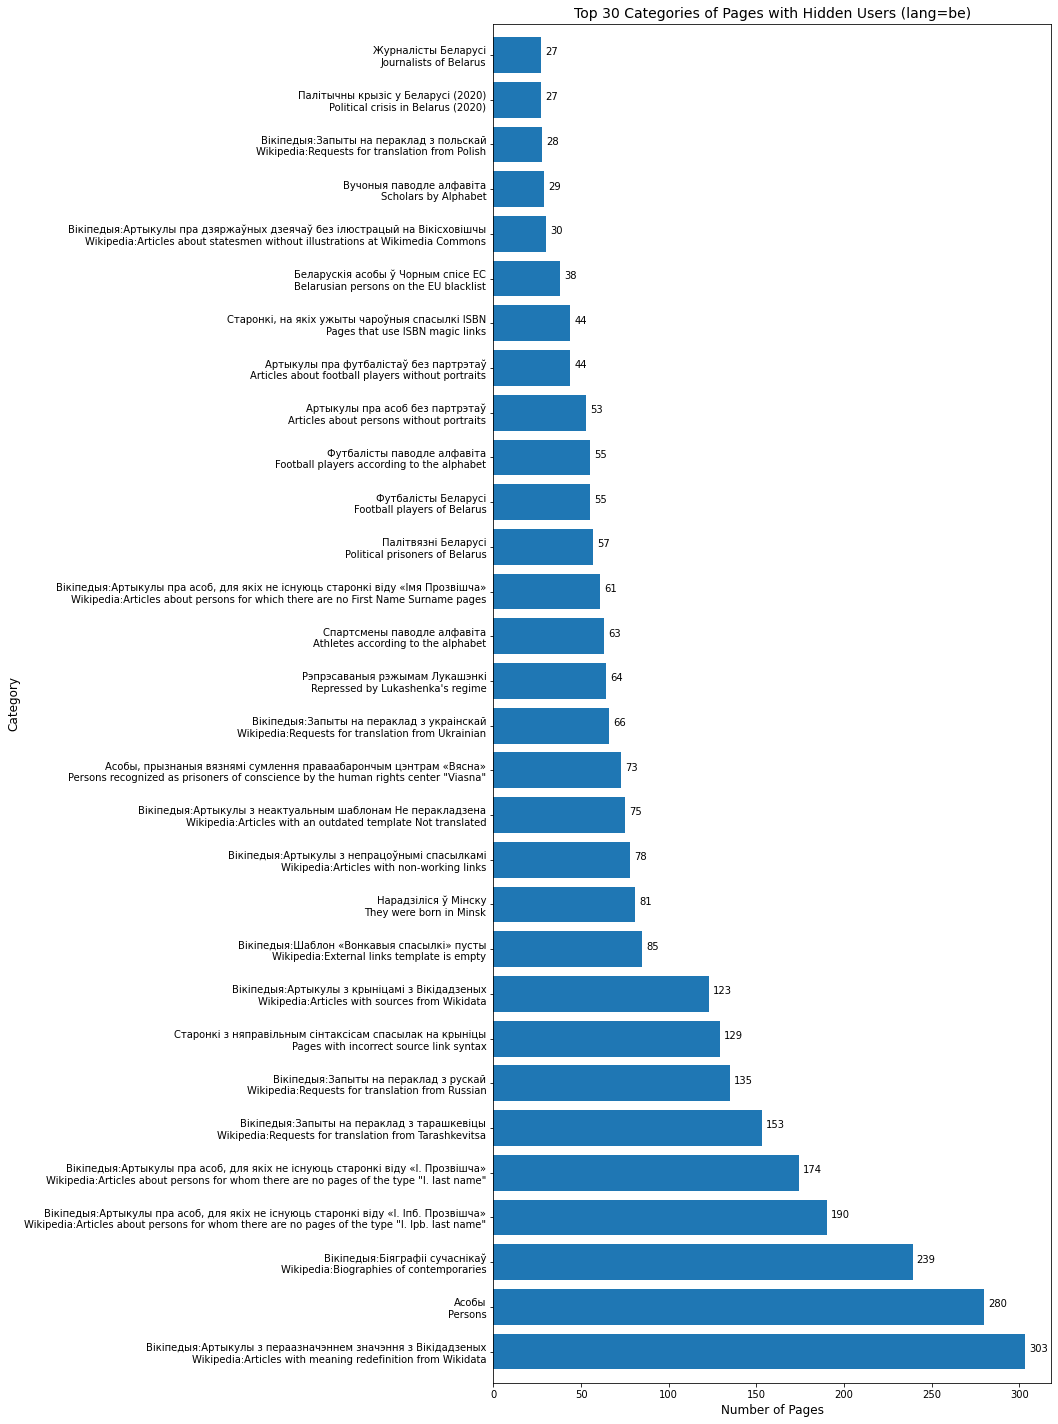

In [ ]:
from collections import Counter
from googletrans import Translator
import matplotlib.pyplot as plt
import os

tlr = Translator()
topk = 30
LANG = 'be' # 'ru'
path = './drive/MyDrive/Marvin/{}.wp'
# logs = [('{}_hidden_merged_dedup_categ.csv', 'Hidden'), ('{}_mixed_merged_dedup_categ.csv', 'Partially Hidden')]
logs = [('be_220512_categ.csv', 'Hidden')]

for log, title in logs:
  fpath = os.path.join(path.format(LANG), log.format(LANG))
  print(fpath)
  categs = read_categ(fname=fpath, lang=LANG)
  categories = Counter(categs)
  print(categories)
  kv = list(categories.items())
  kv = sorted(kv, key=lambda kv: kv[1], reverse=True)[:topk]

  x = [pt[0].strip() for pt in kv]
  x_tld = [tlr.translate(v, src = LANG, dest='en').text for v in x]
  x = [v + '\n' + w for v, w in zip(x, x_tld)]

  y = [pt[1] for pt in kv]

  fig, ax = plt.subplots(figsize=(10, 25))

  for i, v in enumerate(y):
    ax.text(v + 2.4, i, str(v), color='black')
  plt.xlabel('Number of Pages', fontsize=12)
  plt.ylabel('Category', fontsize=12)
  h = plt.barh(x, y)
  plt.margins(y=.01)
  ax.set_title('Top {} Categories of Pages with {} Users (lang={})'.format(topk, title, LANG), fontsize=14)
  plt.savefig(fpath + '_top{}.png'.format(topk), bbox_inches="tight",
              format='png', pad_inches=0.3, transparent=False,
              dpi=500)
